In [1]:
import sys 
sys.path.append('../')
import pandas as pd 
import numpy as np 
import ta
import sqlite3 as sql
import matplotlib.pyplot as plt 
from backtester import * 
from fxcmtoken import major_forex_pairs

In [2]:
print(major_forex_pairs)
conn = sql.connect('../PriceData/PriceData_m5.db')
ticker = major_forex_pairs[0]
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
for col in ['open', 'close', 'high', 'low']:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
conn.close()
data

['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']


,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,close,high,low
date,,,,,,,,,,,,,
2021-08-31 03:50:00,1.18172,1.18187,1.18188,1.18172,1.18185,1.18199,1.18201,1.18184,397,1.181785,1.181930,1.181945,1.181780
2021-08-31 03:55:00,1.18187,1.18189,1.18193,1.18174,1.18199,1.18201,1.18204,1.18187,429,1.181930,1.181950,1.181985,1.181805
2021-08-31 04:00:00,1.18189,1.18182,1.18190,1.18173,1.18201,1.18193,1.18201,1.18185,432,1.181950,1.181875,1.181955,1.181790
2021-08-31 04:05:00,1.18182,1.18191,1.18192,1.18178,1.18193,1.18204,1.18204,1.18191,294,1.181875,1.181975,1.181980,1.181845
2021-08-31 04:10:00,1.18191,1.18193,1.18201,1.18188,1.18204,1.18205,1.18213,1.18200,486,1.181975,1.181990,1.182070,1.181940
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-18 13:15:00,1.15994,1.16033,1.16036,1.15994,1.16008,1.16044,1.16047,1.16008,1428,1.160010,1.160385,1.160415,1.160010
2021-10-18 13:20:00,1.16033,1.16071,1.16073,1.16033,1.16045,1.16084,1.16085,1.16044,1301,1.160390,1.160775,1.160790,1.160385
2021-10-18 13:25:00,1.16072,1.16103,1.16110,1.16063,1.16084,1.16115,1.16122,1.16075,1235,1.160780,1.161090,1.161160,1.160690


In [5]:
window = 20
donchian = ta.volatility.DonchianChannel(high=data['high'], low=data['low'], close=data['close'], window=window, fillna=False)
data['don_h'] = donchian.donchian_channel_hband()
data['don_l'] = donchian.donchian_channel_lband()
data['don_m'] = donchian.donchian_channel_mband()

In [7]:
data.dropna(inplace=True)

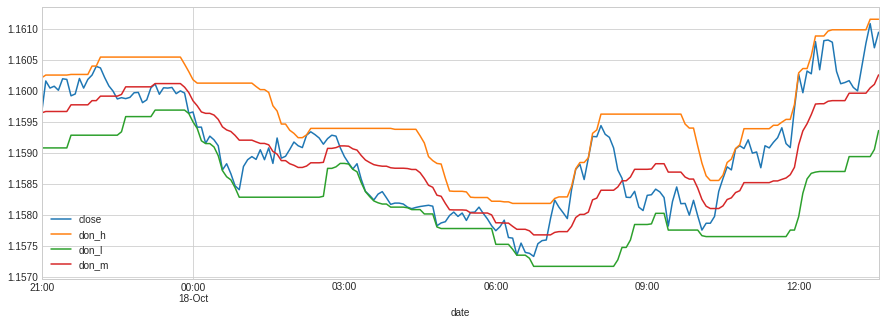

In [11]:
data[['close', 'don_h', 'don_l', 'don_m']].iloc[-200:].plot(figsize=(15,5))
plt.show()

In [12]:
data['don_p'] = donchian.donchian_channel_pband()

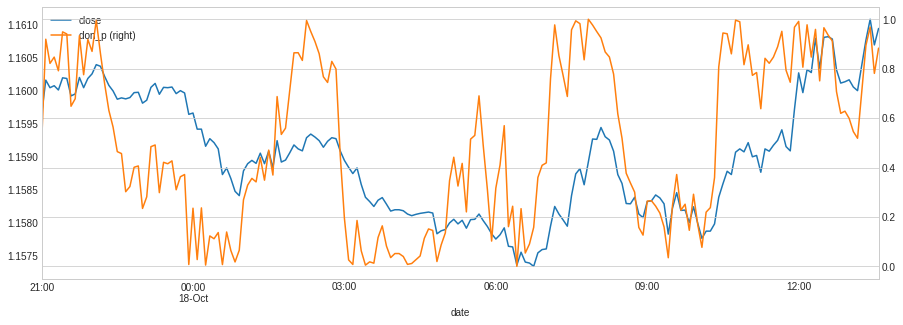

In [17]:
data[['close','don_p']].iloc[-200:].plot(figsize=(15,5), secondary_y='don_p')
plt.show()

In [44]:
data['don_p'].describe()

count    9981.000000
mean        0.490506
std         0.297523
min         0.000000
25%         0.227273
50%         0.483871
75%         0.751880
max         1.000000
Name: don_p, dtype: float64

In [29]:
# percentage = (close - low)/(high - low)
(data['close'] - data['don_l']) / (data['don_h'] - data['don_l']) == data['don_p']

date
2021-08-31 05:25:00    True
2021-08-31 05:30:00    True
2021-08-31 05:35:00    True
2021-08-31 05:40:00    True
2021-08-31 05:45:00    True
                       ... 
2021-10-18 13:15:00    True
2021-10-18 13:20:00    True
2021-10-18 13:25:00    True
2021-10-18 13:30:00    True
2021-10-18 13:35:00    True
Length: 9981, dtype: bool

In [40]:
data['signal'] = np.where(data['don_p'] > 0.8, -1,
                          np.where(data['don_p'] < 0.2, 1, np.nan))
data['signal'] = data['signal'].ffill().fillna(0)

In [41]:
data['signal'].value_counts()

 1.0    5027
-1.0    4953
 0.0       1
Name: signal, dtype: int64

In [42]:
data['signal'].diff(1).apply(np.abs).value_counts()

0.0    9565
2.0     414
1.0       1
Name: signal, dtype: int64

  0%|          | 0/9980 [00:00<?, ?it/s]

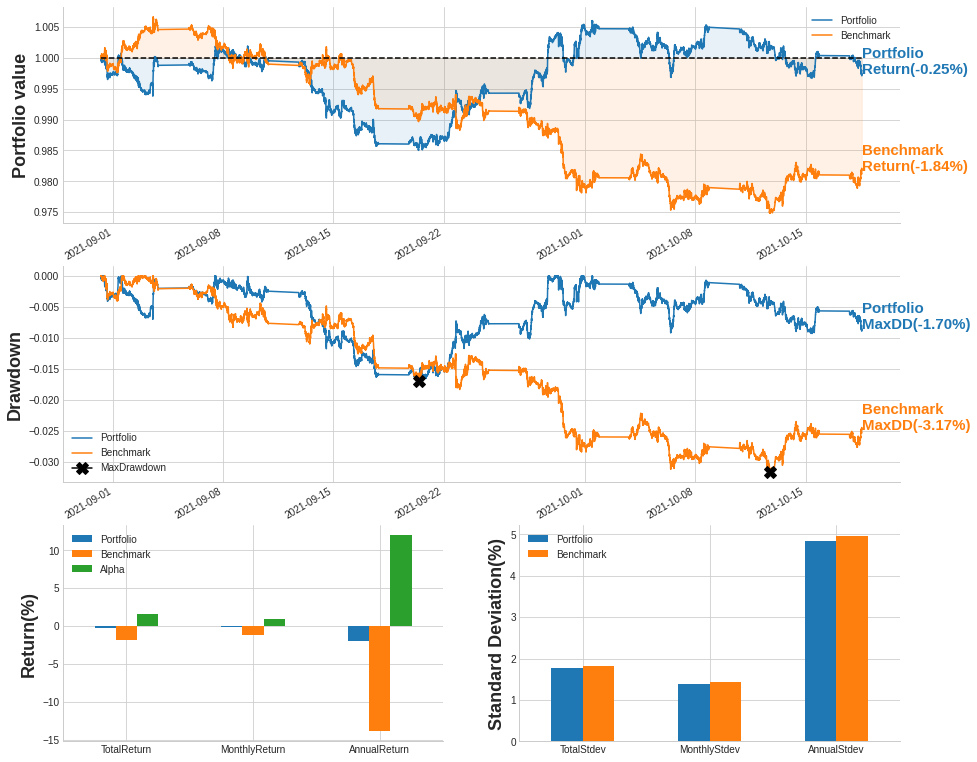

----------------------------------------------------------------------
Data length: |48 days 08:10:00|
Data range from |2021-08-31 05:25:00| to |2021-10-18 13:35:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │      -0.254 │      -1.842 │   1.588 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -0.157 │      -1.143 │   0.985 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      -1.916 │     -13.905 │  11.989 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │   

In [43]:
backtest = IterativeBacktester(data, data['signal'], 'm5')
backtest.backtest()
backtest.results()